In [2]:
import sys
sys.path.insert(0,'/Users/thomasdodd/Library/CloudStorage/OneDrive-MillfieldEnterprisesLimited/github/Omphalos')
sys.path.insert(1,'/Users/thomasdodd/Library/CloudStorage/OneDrive-MillfieldEnterprisesLimited/github')
import numpy as np
import pandas as pd
import xarray as xr

import wandb
import xgboost as xgb
import re

from importlib import reload

# Import Omphalos modules.
from omphalos import file_methods as fm
from omphalos import attributes as attr
from omphalos import labels as lbls
from analysis import helper as hp

from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split

random_state = 69
np.random.state = random_state
np.random.seed = random_state

/Users/thomasdodd/opt/anaconda3/envs/omphalos/lib/python3.10/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


# Training Data Import & Cleaning

In [11]:
# Port in and unpack all the runs we need from the .pkl file.
TrainSet_cl_dict_1 = fm.unpickle('/Users/thomasdodd/Library/CloudStorage/OneDrive-MillfieldEnterprisesLimited/cambridge/ai4er/easter/mres/CrunchFlow_Work/bcm/2022-05-31_bcm_4-1/basalt_cl-.pkl')
TrainSet_cl_dict_2 = fm.unpickle('/Users/thomasdodd/Library/CloudStorage/OneDrive-MillfieldEnterprisesLimited/cambridge/ai4er/easter/mres/CrunchFlow_Work/bcm/2022-05-31_bcm_4-1/basalt_cl-_2.pkl')

4992
9986


In [18]:
# Merging the two dictionaries
TrainSet_cl_1_len = len(TrainSet_cl_dict_1.keys())
TrainSet_cl_2_len = len(TrainSet_cl_dict_2.keys())
# Creating an array of all the keys in second dict
TrainSet_cl_2_OldKeys_arr = []
for key in TrainSet_cl_dict_2.keys():
    TrainSet_cl_2_OldKeys_arr.append(key)
# Creating an array of all the new key numbers needed
TrainSet_cl_2_NewKeys_arr = [x + TrainSet_cl_1_len for x in TrainSet_cl_2_OldKeys_arr]
# Creating a new dictionary of old keys : new keys
TrainSet_cl_2_OldNewKeys_dict = dict(zip(TrainSet_cl_2_OldKeys_arr, TrainSet_cl_2_NewKeys_arr))
# Updating the keys in the second dictionary using the new dictionary of old keys : new keys
TrainSet_cl_dict_2 = dict([(TrainSet_cl_2_OldNewKeys_dict.get(key), value) for key, value in TrainSet_cl_dict_2.items()])
# Merge the two different dictionaries with their newly continuous sets of keys
TrainSet_cl_dict = TrainSet_cl_dict_1 | TrainSet_cl_dict_2

14978


In [19]:
# Filter all errored files out of the dictionary
dataset_dict, error_dict = hp.filter_errors(TrainSet_cl_dict)

Returned 14901 files without errors out of a total possible 14978.
77 files had errors.
0 files had unhandled errors.
File failure rate: 0.5167438426951211 %.
To see unhandled errors, run with verbose=True.


In [20]:
# Get a df of all the start attributes of interest
attributes_all_df = attr.get_condition(dataset_dict,"basalt",species_concs=True)
attributes_all_df = attributes_all_df.loc[:, ['Ca++', 'Fe++', 'Mg++']]
attributes_all_df

/Users/thomasdodd/Library/CloudStorage/OneDrive-MillfieldEnterprisesLimited/github/Omphalos/omphalos/attributes.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  species_attrs = species_attrs.append(primary_species(data_set[i], condition), ignore_index=True)


,Ca++,Fe++,Mg++
0,0.000017,0.000253,0.000103
1,0.000135,0.000168,0.000169
2,0.000069,0.000119,0.000051
3,0.000079,0.000218,0.000222
4,0.000236,0.000180,0.000211
...,...,...,...
14896,0.000037,0.000194,0.000083
14897,0.000235,0.000131,0.000090
14898,0.000262,0.000144,0.000178
14899,0.000242,0.000246,0.000028


In [21]:
def NrFormatFixer_XYZTime(xr_DataSet):
    for _ in xr_DataSet.X.values:
        for __ in xr_DataSet.Y.values:
            for ___ in xr_DataSet.Z.values:
                for ____ in xr_DataSet.time.values:
                    for _____ in xr_DataSet.data_vars:
                        xr_DataArray = xr_DataSet[f'{_____}'].loc[dict(X=f'{_}',Y=f'{__}',Z=f'{___}',time=f'{____}')]
                        for ______ in range(0,len(xr_DataArray)):
                            string = str(xr_DataArray.values[______])
                            new_val = string
                            if re.match("^\d+\.\d+-\d+$",string):
                                i_rev = 1
                                str_len = len(string)
                                for _______ in reversed(string):
                                    if _______ == "-":
                                        break
                                    else:
                                        i_rev+=1
                                        continue
                                i = str_len - i_rev
                                new_string = string[:i] + "e" + string[i:]
                                new_val = new_string
                            xr_DataArray.values[______] = new_val
    return xr_DataSet

In [22]:
def NrFormatFixer_XYZ(xr_DataSet):
    for _ in xr_DataSet.X.values:
        for __ in xr_DataSet.Y.values:
            for ___ in xr_DataSet.Z.values:
                for _____ in xr_DataSet.data_vars:
                    xr_DataArray = xr_DataSet[f'{_____}'].loc[dict(X=f'{_}',Y=f'{__}',Z=f'{___}')]
                    for ______ in range(0,len(xr_DataArray)):
                        string = str(xr_DataArray.values[______])
                        new_val = string
                        if re.match("^\d+\.\d+-\d+$",string):
                            i_rev = 1
                            str_len = len(string)
                            for _______ in reversed(string):
                                if _______ == "-":
                                    break
                                else:
                                    i_rev+=1
                                    continue
                            i = str_len - i_rev
                            new_string = string[:i] + "e" + string[i:]
                            new_val = new_string
                        xr_DataArray.values[______] = new_val
    return xr_DataSet

In [23]:
# Retrieval of xarray datasets containing final and initial mineralogical volume fractions
FinalVols_ds = lbls.raw(dataset_dict, 'volume')
FinalVols_ds = NrFormatFixer_XYZTime(FinalVols_ds)
FinalVols_ds = FinalVols_ds.astype(float)

InitialVols_ds = attr.initial_conditions(dataset_dict, concentrations=False, minerals=True)
InitialVols_ds = NrFormatFixer_XYZ(InitialVols_ds)
InitialVols_ds = InitialVols_ds.astype(float)

# Generation of an xarray dataset representing change in mineralogical volume fractions
DeltVolFrac_ds = FinalVols_ds - InitialVols_ds

# Generation of an narrowed-down xarray dataset containing only data on a specific time and place
DeltVolFrac_TenYr_ds = DeltVolFrac_ds.sel(X=0.5,Y=0.5,Z=0.5,time=10)

# Generation of an additional xarray variable entitled Carbonates; placed into the above xarray dataset
DeltVolFrac_TenYr_ds = DeltVolFrac_TenYr_ds.assign(Carbonates=lambda DeltVolFrac_TenYr_ds: DeltVolFrac_TenYr_ds.Calcite + DeltVolFrac_TenYr_ds.Siderite + DeltVolFrac_TenYr_ds.Magnesite)

# XGBoost Model Training

In [24]:
# For the ML problem define attributes and labels datasets
attributes = attributes_all_df
labels = DeltVolFrac_TenYr_ds

# Split the ML datasets into x's (predictor arrays) and y's (target arrays)
x = attributes.loc[:, ['Ca++', 'Fe++','Mg++']].astype(float)
y = DeltVolFrac_TenYr_ds.Carbonates.values.astype(float)

# Generate a numpy matrix from a pandas dataframe
x = x.to_numpy()

def NormalizeData(data, lower, upper):
    return (data - lower) / (upper - lower)

x_upper_normalizer = 3.0E-4 # max(data)
x_lower_normalizer = 0 # min(data)

y_upper_normalizer = 0.0019470942119 # max(data)
y_lower_normalizer = 0.0019468777495 # min(data)

x = NormalizeData(x, x_lower_normalizer, x_upper_normalizer)
y = NormalizeData(y, y_lower_normalizer, y_upper_normalizer)
y = y.reshape(-1,1)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=random_state)

In [25]:
%%time

xgb_defaults = {
    'tree_method': 'hist',
    'gamma': 0,
    'mds': 0,
    'eta': 0.01,
    'l1' : 0,
    'l2' : 1,
    'max_depth' : 0,
    'max_leaves': 6,
    'objective': 'reg:squarederror',
    'max_bin': 10000,
    'grow_policy': 'lossguide'
}

# Initialise the wandb instance
wandb.init(config=xgb_defaults, project='bcm_4-1')

# Setup xgb matrices; one for training and one testing
dtrain = xgb.DMatrix(x_train, label=y_train)
dtest = xgb.DMatrix(x_test, label=y_test)

evallist = [(dtest, 'eval'), (dtrain, 'train')]

params = {'max_depth': wandb.config.max_depth,
            'tree_method': wandb.config.tree_method,
            'max_delta_step': wandb.config.mds,
            'eta': wandb.config.eta,
            'objective': wandb.config.objective,
            'alpha': wandb.config.l1,
            'lambda': wandb.config.l2,
            'gamma': wandb.config.gamma,
            'max_leaves': wandb.config.max_leaves,
            'max_bin': wandb.config.max_bin,
            'grow_policy': wandb.config.grow_policy
        }

results = {}

num_round = 4000
bst = xgb.train(params, dtrain, num_round, evallist, evals_result=results, verbose_eval=False, callbacks=[wandb.xgboost.WandbCallback()])
wandb.log({"val_loss" : results['rmse'][-1]})

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: tjhd97. Use `wandb login --relogin` to force relogin


KeyError: 'rmse'

In [26]:
bst.save_model("bcm_xgbModel_4-1.json")

# Comparison Data Import and Cleaning

In [27]:
# Port in and unpack all the runs we need from the .pkl file.
CtrlSet_ca_dict = fm.unpickle('/Users/thomasdodd/Library/CloudStorage/OneDrive-MillfieldEnterprisesLimited/cambridge/ai4er/easter/mres/CrunchFlow_Work/bcm/2022-05-31_bcm_4-1/control_ca/basalt_cl-_ctrl-ca++_2.pkl')
CtrlSet_fe_dict = fm.unpickle('/Users/thomasdodd/Library/CloudStorage/OneDrive-MillfieldEnterprisesLimited/cambridge/ai4er/easter/mres/CrunchFlow_Work/bcm/2022-05-31_bcm_4-1/control_fe/basalt_cl-_ctrl-fe++_2.pkl')
CtrlSet_mg_dict = fm.unpickle('/Users/thomasdodd/Library/CloudStorage/OneDrive-MillfieldEnterprisesLimited/cambridge/ai4er/easter/mres/CrunchFlow_Work/bcm/2022-05-31_bcm_4-1/control_mg/basalt_cl-_ctrl-mg++_2.pkl')

In [28]:
# Create a number of datasets from the control RTM experiments
dataset_ca_dict, error_dict = hp.filter_errors(CtrlSet_ca_dict)
dataset_fe_dict, error_dict = hp.filter_errors(CtrlSet_fe_dict)
dataset_mg_dict, error_dict = hp.filter_errors(CtrlSet_mg_dict)

Returned 100 files without errors out of a total possible 100.
0 files had errors.
0 files had unhandled errors.
File failure rate: 0.0 %.
To see unhandled errors, run with verbose=True.
Returned 100 files without errors out of a total possible 100.
0 files had errors.
0 files had unhandled errors.
File failure rate: 0.0 %.
To see unhandled errors, run with verbose=True.
Returned 100 files without errors out of a total possible 100.
0 files had errors.
0 files had unhandled errors.
File failure rate: 0.0 %.
To see unhandled errors, run with verbose=True.


In [29]:
# Get all the attribute df's for the control RTM experiments
attributes_ca_df = attr.get_condition(dataset_ca_dict,"basalt",species_concs=True)
attributes_ca_df = attributes_ca_df.loc[:, ['Ca++', 'Fe++', 'Mg++']]
attributes_fe_df = attr.get_condition(dataset_fe_dict,"basalt",species_concs=True)
attributes_fe_df = attributes_fe_df.loc[:, ['Ca++', 'Fe++', 'Mg++']]
attributes_mg_df = attr.get_condition(dataset_mg_dict,"basalt",species_concs=True)
attributes_mg_df = attributes_mg_df.loc[:, ['Ca++', 'Fe++', 'Mg++']]

/Users/thomasdodd/Library/CloudStorage/OneDrive-MillfieldEnterprisesLimited/github/Omphalos/omphalos/attributes.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  species_attrs = species_attrs.append(primary_species(data_set[i], condition), ignore_index=True)
/Users/thomasdodd/Library/CloudStorage/OneDrive-MillfieldEnterprisesLimited/github/Omphalos/omphalos/attributes.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  species_attrs = species_attrs.append(primary_species(data_set[i], condition), ignore_index=True)
/Users/thomasdodd/Library/CloudStorage/OneDrive-MillfieldEnterprisesLimited/github/Omphalos/omphalos/attributes.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  species_attrs = species_attrs.append(primary

In [30]:
# Retrieval of xarray datasets containing final and initial mineralogical volume fractions for the control RTM experiments

# Final mineralogical volumes xarray datasets
FinalVols_ca_ds = lbls.raw(dataset_ca_dict, 'volume')
FinalVols_ca_ds = NrFormatFixer_XYZTime(FinalVols_ca_ds)
FinalVols_ca_ds = FinalVols_ca_ds.astype(float)
FinalVols_fe_ds = lbls.raw(dataset_fe_dict, 'volume')
FinalVols_fe_ds = NrFormatFixer_XYZTime(FinalVols_fe_ds)
FinalVols_fe_ds = FinalVols_fe_ds.astype(float)
FinalVols_mg_ds = lbls.raw(dataset_mg_dict, 'volume')
FinalVols_mg_ds = NrFormatFixer_XYZTime(FinalVols_mg_ds)
FinalVols_mg_ds = FinalVols_mg_ds.astype(float)

# Start mineralogical volumes xarray datasets
InitialVols_ca_ds = attr.initial_conditions(dataset_ca_dict, concentrations=False, minerals=True)
InitialVols_ca_ds = NrFormatFixer_XYZ(InitialVols_ca_ds)
InitialVols_ca_ds = InitialVols_ca_ds.astype(float)
InitialVols_fe_ds = attr.initial_conditions(dataset_fe_dict, concentrations=False, minerals=True)
InitialVols_fe_ds = NrFormatFixer_XYZ(InitialVols_fe_ds)
InitialVols_fe_ds = InitialVols_fe_ds.astype(float)
InitialVols_mg_ds = attr.initial_conditions(dataset_fe_dict, concentrations=False, minerals=True)
InitialVols_mg_ds = NrFormatFixer_XYZ(InitialVols_mg_ds)
InitialVols_mg_ds = InitialVols_mg_ds.astype(float)

# Generation of an xarray dataset representing change in mineralogical volume fractions
DeltVolFrac_ca_ds = FinalVols_ca_ds - InitialVols_ca_ds
DeltVolFrac_fe_ds = FinalVols_fe_ds - InitialVols_fe_ds
DeltVolFrac_mg_ds = FinalVols_mg_ds - InitialVols_mg_ds

# Generation of an narrowed-down xarray dataset containing only data on a specific time and place
DeltVolFrac_ca_TenYr_ds = DeltVolFrac_ca_ds.sel(X=0.5,Y=0.5,Z=0.5,time=10)
DeltVolFrac_fe_TenYr_ds = DeltVolFrac_fe_ds.sel(X=0.5,Y=0.5,Z=0.5,time=10)
DeltVolFrac_mg_TenYr_ds = DeltVolFrac_mg_ds.sel(X=0.5,Y=0.5,Z=0.5,time=10)

# Generation of an additional xarray variable entitled Carbonates; placed into the above xarray dataset
DeltVolFrac_ca_TenYr_ds = DeltVolFrac_ca_TenYr_ds.assign(Carbonates=lambda DeltVolFrac_ca_TenYr_ds: DeltVolFrac_ca_TenYr_ds.Calcite + DeltVolFrac_ca_TenYr_ds.Siderite + DeltVolFrac_ca_TenYr_ds.Magnesite)
DeltVolFrac_fe_TenYr_ds = DeltVolFrac_fe_TenYr_ds.assign(Carbonates=lambda DeltVolFrac_fe_TenYr_ds: DeltVolFrac_fe_TenYr_ds.Calcite + DeltVolFrac_fe_TenYr_ds.Siderite + DeltVolFrac_fe_TenYr_ds.Magnesite)
DeltVolFrac_mg_TenYr_ds = DeltVolFrac_mg_TenYr_ds.assign(Carbonates=lambda DeltVolFrac_mg_TenYr_ds: DeltVolFrac_mg_TenYr_ds.Calcite + DeltVolFrac_mg_TenYr_ds.Siderite + DeltVolFrac_mg_TenYr_ds.Magnesite)

In [31]:
# Control Experiments
# Split the datasets into x's and y's
# Normalise the control x's and y's in the same way as the training data

# Control 1 - Ca++ Varied, Fe++/Mg++ Held-Steady
x_ca = attributes_ca_df.loc[:, ['Ca++', 'Fe++','Mg++']].astype(float)
y_ca = DeltVolFrac_ca_TenYr_ds.Carbonates.values.astype(float)

x_ca = x_ca.to_numpy()
x_ca = NormalizeData(x_ca, x_lower_normalizer, x_upper_normalizer)
y_ca = NormalizeData(y_ca, y_lower_normalizer, y_upper_normalizer)
y_ca = y_ca.reshape(-1,1)


# Control 2 - Fe++ Varied, Ca++/Mg++ Held-Steady
x_fe = attributes_fe_df.loc[:, ['Ca++', 'Fe++','Mg++']].astype(float)
y_fe = DeltVolFrac_fe_TenYr_ds.Carbonates.values.astype(float)

x_fe = x_fe.to_numpy()
x_fe = NormalizeData(x_fe, x_lower_normalizer, x_upper_normalizer)
y_fe = NormalizeData(y_fe, y_lower_normalizer, y_upper_normalizer)
y_fe = y_fe.reshape(-1,1)


# Prediction 3 - Mg++ Varied, Ca++/Fe++ Held-Steady
x_mg = attributes_mg_df.loc[:, ['Ca++', 'Fe++','Mg++']].astype(float)
y_mg = DeltVolFrac_mg_TenYr_ds.Carbonates.values.astype(float)

x_mg = x_mg.to_numpy()
x_mg = NormalizeData(x_mg, x_lower_normalizer, x_upper_normalizer)
y_mg = NormalizeData(y_mg, y_lower_normalizer, y_upper_normalizer)
y_mg = y_mg.reshape(-1,1)

# Comparison of RTM Ground Truth and XGB Predictions

In [32]:
# Prediction Experiments

# The variable as varied between lower and upper bounds
variable_range_lower, variable_range_upper = 0, 3.0E-4
# The controlled values in the base .in file
controlled_ca_val = 1.0922841574764136E-4
controlled_fe_val = 2.0458518197753574E-4
controlled_mg_val = 2.8166497794217927E-4

# The number of ypred value samples desired
samples = 100
# The number dimensions (i.e. predictors i.e. ca, fe, mg)
dims = 3

# Prediction 1 - Ca++ Varied, Fe++/Mg++ Held-Steady
pred_ca_matrix = np.ones((samples, dims))
pred_ca_matrix[:,0] = np.linspace(variable_range_lower, variable_range_upper, samples)
pred_ca_matrix[:,1] = controlled_fe_val
pred_ca_matrix[:,2] = controlled_mg_val
pred_ca_matrix = NormalizeData(pred_ca_matrix, x_lower_normalizer, x_upper_normalizer)
xpred_ca = pred_ca_matrix[:,0]
ypred_ca = bst.predict(xgb.DMatrix(pred_ca_matrix))

# Prediction 2 - Fe++ Varied, Ca++/Mg++ Held-Steady
pred_fe_matrix = np.ones((samples, dims))
pred_fe_matrix[:,0] = controlled_ca_val
pred_fe_matrix[:,1] = np.linspace(variable_range_lower, variable_range_upper, samples)
pred_fe_matrix[:,2] = controlled_mg_val
pred_fe_matrix = NormalizeData(pred_fe_matrix, x_lower_normalizer, x_upper_normalizer)
xpred_fe = pred_fe_matrix[:,1]
ypred_fe = bst.predict(xgb.DMatrix(pred_fe_matrix))

# Prediction 3 - Mg++ Varied, Ca++/Fe++ Held-Steady
pred_mg_matrix = np.ones((samples, dims))
pred_mg_matrix[:,0] = controlled_ca_val
pred_mg_matrix[:,1] = controlled_fe_val
pred_mg_matrix[:,2] = np.linspace(variable_range_lower, variable_range_upper, samples)
pred_mg_matrix = NormalizeData(pred_mg_matrix, x_lower_normalizer, x_upper_normalizer)
xpred_mg = pred_mg_matrix[:,2]
ypred_mg = bst.predict(xgb.DMatrix(pred_mg_matrix))

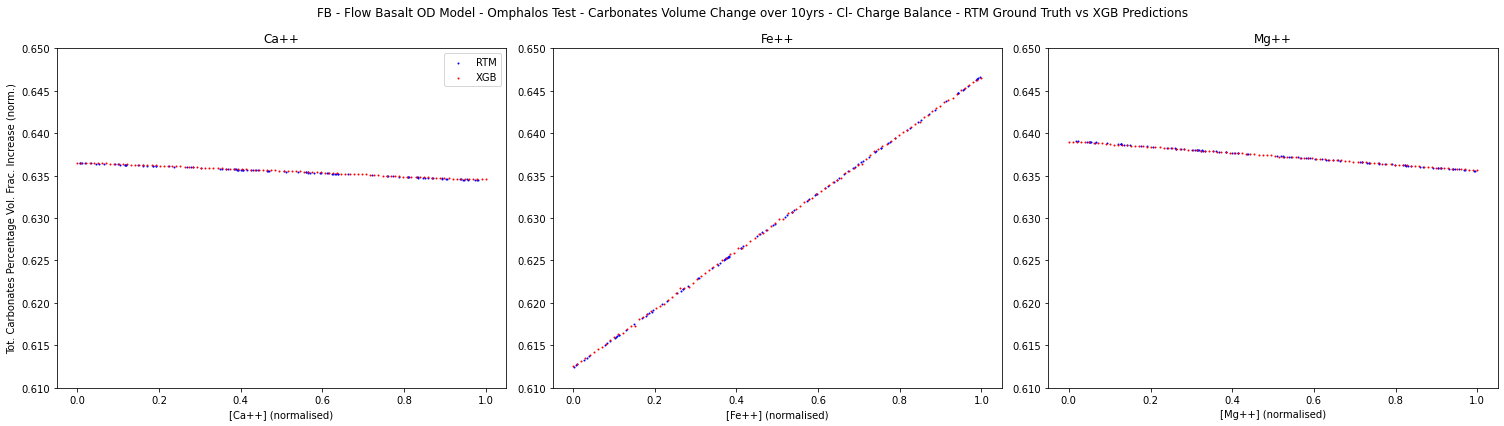

In [33]:
# Plotting the control RTM experiments against predictions made by the XGBoost Model
fig, ((ax1),(ax2),(ax3)) = plt.subplots(1,3)
fig.suptitle('FB - Flow Basalt OD Model - Omphalos Test - Carbonates Volume Change over 10yrs - Cl- Charge Balance - RTM Ground Truth vs XGB Predictions')

fig.set_figheight(6)
fig.set_figwidth(21)

ax1.set_title("Ca++", loc='center')
ax2.set_title("Fe++", loc='center')
ax3.set_title("Mg++", loc='center')

ax1.set_ylabel('Tot. Carbonates Percentage Vol. Frac. Increase (norm.)')

ax1.set_xlabel('[Ca++] (normalised)')
ax2.set_xlabel('[Fe++] (normalised)')
ax3.set_xlabel('[Mg++] (normalised)')

ax1.set_ylim(0.61,0.65)
ax2.set_ylim(0.61,0.65)
ax3.set_ylim(0.61,0.65)

# ax1.set_ylim(0,1)
# ax2.set_ylim(0,1)
# ax3.set_ylim(0,1)

ax1_x_rtm = x_ca[:,0]
ax1_y_rtm = y_ca
ax1_x_xgb = xpred_ca
ax1_y_xgb = ypred_ca

ax2_x_rtm = x_fe[:,1]
ax2_y_rtm = y_fe
ax2_x_xgb = xpred_fe
ax2_y_xgb = ypred_fe

ax3_x_rtm = x_mg[:,2]
ax3_y_rtm = y_mg
ax3_x_xgb = xpred_mg
ax3_y_xgb = ypred_mg

ax1.scatter(x=ax1_x_rtm, y=ax1_y_rtm, c='blue', s=1, alpha=1, label="RTM")
ax1.scatter(x=ax1_x_xgb, y=ax1_y_xgb, c='red', s=1, alpha=1, label="XGB")
ax2.scatter(x=ax2_x_rtm, y=ax2_y_rtm, c='blue', s=1, alpha=1, label="RTM")
ax2.scatter(x=ax2_x_xgb, y=ax2_y_xgb, c='red', s=1, alpha=1, label="XGB")
ax3.scatter(x=ax3_x_rtm, y=ax3_y_rtm, c='blue', s=1, alpha=1, label="RTM")
ax3.scatter(x=ax3_x_xgb, y=ax3_y_xgb, c='red', s=1, alpha=1, label="XGB")

ax1.legend()

plt.tight_layout()